## Import Libraries and Datasets

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import sklearn.preprocessing as skpre
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time

import DataProcessor
import SRMSE
import VAE

In [2]:
# Load in the persons PUMS dataset for WA state
h_df = pd.read_csv("data/PUMS_2017_5YR_WA/psam_h53.csv")

## Choose PUMS and Preprocess

In [3]:
# Filter to desired variables (numeric then categorical)
pums_data = h_df[['HINCP','NP','VEH','BLD','ACCESS']].copy()

# Convert numerical variables to categorical bins
pums_data['HINCP'], hincp_bins = pd.qcut(pums_data['HINCP'], q=10, labels=False, retbins=True)

# Remove NA values and check n before/after
print(f"Dataset n={len(pums_data)} pre-cleaning")
pums_data = pums_data.dropna()
print(f"Dataset n={len(pums_data)} post-cleaning")

Dataset n=164836 pre-cleaning
Dataset n=140586 post-cleaning


In [4]:
VAR_DIM = pums_data.shape[1]
VAR_NAMES = pums_data.columns

# Split categorical data into OHE vars, save num classes per variable
dummies_list = []
pums_encodings_list = []
for x in range(VAR_DIM):
    dummies = pums_data.iloc[:,x]
    pums_encodings_list.append(np.unique(dummies.values))
    dummies = pd.get_dummies(dummies, prefix=f"{pums_data.columns[x]}_")
    dummies_list.append(dummies)
CAT_LENGTHS = [x.shape[1] for x in dummies_list]

In [5]:
# Final data frame after encoding OHE
model_data_df = pd.DataFrame()
for ohe_var in dummies_list:
    model_data_df = pd.concat([model_data_df, ohe_var], axis=1)
MANIFEST_DIM = model_data_df.shape[1]

# Preview data that will be fed into model
model_data_df

,HINCP__0.0,HINCP__1.0,HINCP__2.0,HINCP__3.0,HINCP__4.0,HINCP__5.0,HINCP__6.0,HINCP__7.0,HINCP__8.0,HINCP__9.0,...,BLD__4.0,BLD__5.0,BLD__6.0,BLD__7.0,BLD__8.0,BLD__9.0,BLD__10.0,ACCESS__1.0,ACCESS__2.0,ACCESS__3.0
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161771,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
161772,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
161774,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
161775,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [6]:
# Separate into train/test data
model_data = model_data_df.values
train_idx = round(len(model_data)*.003)
train_data = model_data[0:train_idx,:]
test_data = model_data[train_idx:len(model_data),:]

print(f"Training on {train_idx} samples")

Training on 422 samples


## Set Parameters and Define Model

In [7]:
# Grid Search SRMSE 1
# BATCH_SIZES = [64, 128, 256, 512, 1024]
# EPOCHS = [1000]
# LATENT_DIMS = [2, 3, 4]
# HIDDEN_DIMS = [8, 16, 32, 64]
# KL_WEIGHTS = [.01, .05, .1, 1.0]
# [155.67232656478882, 1.8501038551330566, 0.05296959012880786, 0.02081236519716125, [128, 1000, 2, 32, 0.05]]
# [98.54442024230957, 1.7626943588256836, 0.06421160670330948, 0.020779257538261826, [256, 1000, 4, 32, 0.1]]
# [44.24084186553955, 2.3369486331939697, 0.06478558327639009, 0.02501131310084622, [1024, 1000, 4, 16, 0.1]]

# Low Data ~40 samples
# BATCH_SIZE = 16
# EPOCHS = 1000
# LATENT_DIM = 2
# HIDDEN_DIM = 16
# KL_WEIGHT = .1

# Hyperparameters
BATCH_SIZE = 16
EPOCHS = 1000
LATENT_DIM = 2
HIDDEN_DIM = 16
KL_WEIGHT = .1

## Training

In [8]:
val_loss = []
val_epochs = []
class validationCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            val_epochs.append(epoch)
            # Use random sample of 1000 from test data to validate the model
            idx = np.random.randint(test_data.shape[0], size=1000)
            val_data = test_data[idx]
            results = vae.predict(val_data)
            loss_cat = VAE.get_reconstruction_loss(val_data, results, CAT_LENGTHS)
            val_loss.append(float(loss_cat))

In [9]:
def testModel(test_vae, latent_dim):
    # How many synthetic households to generate
    POP_SIZE = 100000  # Number of hh in WA

    # Generate random normal sample to represent each latent variable, for each row (different hh per row)
    np.random.seed(42)
    inputs = np.random.normal(loc=0, scale=1, size=(POP_SIZE, latent_dim))

    start_time = time.time()
    # Generate households; each hh has unique latent input
    results = test_vae.decoder.predict([inputs, inputs[:,latent_dim:]])  # Nothing is actually in the second input
    gen_time = time.time() - start_time

    synth_hh_df = pd.DataFrame()
    for i, x in enumerate(results[0]):
        result = np.apply_along_axis(DataProcessor.logit_to_val, 1, x, pums_encodings_list[i])
        result_df = pd.DataFrame(result).add_prefix(f"{VAR_NAMES[i]}_")
        synth_hh_df = pd.concat([synth_hh_df, result_df], axis=1)
    synth_hh_df.columns = VAR_NAMES
    
    # Get univariate and bivariate srmse for the current model
    srmse_uni = SRMSE.calculateSRMSE(synth_hh_df, pums_data.sample(POP_SIZE, random_state=42))
    srmse_bi = SRMSE.calculateBivariateSRMSE(synth_hh_df, pums_data.sample(POP_SIZE, random_state=42))

    return gen_time, srmse_uni, srmse_bi

In [10]:
# HH_IDX = len(CAT_LENGTHS)  # Number of household variables (used in CVAE)

# # Use grid search to train model and get results for many different hyperparameters
# grid_search_results = []
# for bs in BATCH_SIZES:
#     for e in EPOCHS:
#         for ld in LATENT_DIMS:
#             for hd in HIDDEN_DIMS:
#                 for klw in KL_WEIGHTS:
#                     print(f"[{bs}, {e}, {ld}, {hd}, {klw}]")
#                     start_time = time.time()
#                     vae = VAE.VAE(MANIFEST_DIM, hd, ld, CAT_LENGTHS, HH_IDX, klw)
#                     vae.compile(optimizer=keras.optimizers.Adam())
#                     history = vae.fit(train_data, epochs=e, batch_size=bs, callbacks=[validationCallback()], verbose=0)
#                     train_time = (time.time()-start_time)
#                     gen_time, srmse_uni, srmse_bi = testModel(test_vae=vae, latent_dim=ld)
#                     results = [train_time, gen_time, srmse_uni, srmse_bi, [bs,e,ld,hd,klw]]
#                     grid_search_results.append(results)

# # Find the best results for each metric in the grid search
# min_srmse_uni_idx = 0
# min_srmse_uni_value = 999999999
# min_srmse_bi_idx = 0
# min_srmse_bi_value = 999999999
# min_eff_idx = 0
# min_eff_value = 999999999
# for i, result in enumerate(grid_search_results):
#     tot_time = result[0]+result[1]
#     time_eff = (result[2]+result[3] / 2) * tot_time
#     if result[2] < min_srmse_uni_value:
#         min_srmse_uni_idx = i
#         min_srmse_uni_value = result[2]
#     if result[3] < min_srmse_bi_value:
#         min_srmse_bi_idx = i
#         min_srmse_bi_value = result[3]
#     if time_eff < min_eff_value:
#         min_eff_idx = i
#         min_eff_value = time_eff

# # Display the results
# print(grid_search_results[min_srmse_uni_idx])
# print(grid_search_results[min_srmse_bi_idx])
# print(grid_search_results[min_eff_idx])

In [11]:
# Train the model using single set of hyperparameters
HH_IDX = len(CAT_LENGTHS)  # Number of household variables (used in CVAE)
start_time = time.time()

vae = VAE.VAE(MANIFEST_DIM, HIDDEN_DIM, LATENT_DIM, CAT_LENGTHS, HH_IDX, KL_WEIGHT)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[validationCallback()])

train_time = (time.time()-start_time)
print(train_time)

Epoch 1/1000
27/27 [==============================] - 0s 9ms/step - tot_loss: 10.2690 - rec_loss: 10.2372 - kl_loss: 0.0318
Epoch 2/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 9.0965 - rec_loss: 8.9818 - kl_loss: 0.1147
Epoch 3/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 8.1351 - rec_loss: 7.8983 - kl_loss: 0.2368
Epoch 4/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 7.6515 - rec_loss: 7.4174 - kl_loss: 0.2341
Epoch 5/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 7.4219 - rec_loss: 7.2196 - kl_loss: 0.2023
Epoch 6/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 7.3183 - rec_loss: 7.1193 - kl_loss: 0.1990
Epoch 7/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 7.2210 - rec_loss: 7.0121 - kl_loss: 0.2090
Epoch 8/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 7.0425 - rec_loss: 6.8414 - kl_loss: 0.2011
Epoch 9/1000
27/27 [==

27/27 [==============================] - 0s 2ms/step - tot_loss: 5.0561 - rec_loss: 4.7213 - kl_loss: 0.3348
Epoch 68/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 5.0686 - rec_loss: 4.7293 - kl_loss: 0.3393
Epoch 69/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 5.0113 - rec_loss: 4.6711 - kl_loss: 0.3402
Epoch 70/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 5.0091 - rec_loss: 4.6706 - kl_loss: 0.3385
Epoch 71/1000
27/27 [==============================] - 0s 7ms/step - tot_loss: 5.0288 - rec_loss: 4.6929 - kl_loss: 0.3358
Epoch 72/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 5.0165 - rec_loss: 4.6736 - kl_loss: 0.3429
Epoch 73/1000
27/27 [==============================] - 0s 3ms/step - tot_loss: 5.0038 - rec_loss: 4.6592 - kl_loss: 0.3446
Epoch 74/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 4.9753 - rec_loss: 4.6280 - kl_loss: 0.3473
Epoch 75/1000
27/27 [=========

27/27 [==============================] - 0s 2ms/step - tot_loss: 4.5177 - rec_loss: 4.1092 - kl_loss: 0.4085
Epoch 134/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 4.5607 - rec_loss: 4.1583 - kl_loss: 0.4024
Epoch 135/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 4.5302 - rec_loss: 4.1279 - kl_loss: 0.4023
Epoch 136/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 4.5638 - rec_loss: 4.1576 - kl_loss: 0.4063
Epoch 137/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 4.4911 - rec_loss: 4.0838 - kl_loss: 0.4073
Epoch 138/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 4.5176 - rec_loss: 4.1107 - kl_loss: 0.4069
Epoch 139/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 4.4846 - rec_loss: 4.0772 - kl_loss: 0.4075
Epoch 140/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 4.5158 - rec_loss: 4.1032 - kl_loss: 0.4126
Epoch 141/1000
27/27 [=

27/27 [==============================] - 0s 2ms/step - tot_loss: 4.1725 - rec_loss: 3.7276 - kl_loss: 0.4449
Epoch 200/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 4.1466 - rec_loss: 3.6974 - kl_loss: 0.4492
Epoch 201/1000
27/27 [==============================] - 0s 4ms/step - tot_loss: 4.1508 - rec_loss: 3.7050 - kl_loss: 0.4459
Epoch 202/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 4.1632 - rec_loss: 3.7187 - kl_loss: 0.4445
Epoch 203/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 4.1505 - rec_loss: 3.7136 - kl_loss: 0.4370
Epoch 204/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 4.1613 - rec_loss: 3.7177 - kl_loss: 0.4436
Epoch 205/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 4.1076 - rec_loss: 3.6573 - kl_loss: 0.4503
Epoch 206/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 4.1192 - rec_loss: 3.6720 - kl_loss: 0.4472
Epoch 207/1000
27/27 [=

27/27 [==============================] - 0s 1ms/step - tot_loss: 3.8271 - rec_loss: 3.3434 - kl_loss: 0.4837
Epoch 266/1000
27/27 [==============================] - 0s 1ms/step - tot_loss: 3.8102 - rec_loss: 3.3324 - kl_loss: 0.4778
Epoch 267/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 3.8189 - rec_loss: 3.3439 - kl_loss: 0.4751
Epoch 268/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 3.8807 - rec_loss: 3.4016 - kl_loss: 0.4791
Epoch 269/1000
27/27 [==============================] - 0s 1ms/step - tot_loss: 3.8344 - rec_loss: 3.3458 - kl_loss: 0.4886
Epoch 270/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 3.8165 - rec_loss: 3.3275 - kl_loss: 0.4891
Epoch 271/1000
27/27 [==============================] - 0s 6ms/step - tot_loss: 3.8116 - rec_loss: 3.3246 - kl_loss: 0.4870
Epoch 272/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 3.8040 - rec_loss: 3.3228 - kl_loss: 0.4812
Epoch 273/1000
27/27 [=

27/27 [==============================] - 0s 5ms/step - tot_loss: 3.5555 - rec_loss: 3.0529 - kl_loss: 0.5025
Epoch 332/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 3.6094 - rec_loss: 3.1035 - kl_loss: 0.5058
Epoch 333/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 3.5851 - rec_loss: 3.0746 - kl_loss: 0.5105
Epoch 334/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 3.5606 - rec_loss: 3.0458 - kl_loss: 0.5148
Epoch 335/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 3.5666 - rec_loss: 3.0583 - kl_loss: 0.5082
Epoch 336/1000
27/27 [==============================] - 0s 5ms/step - tot_loss: 3.5595 - rec_loss: 3.0502 - kl_loss: 0.5093
Epoch 337/1000
27/27 [==============================] - 0s 3ms/step - tot_loss: 3.5693 - rec_loss: 3.0630 - kl_loss: 0.5063
Epoch 338/1000
27/27 [==============================] - 0s 7ms/step - tot_loss: 3.5470 - rec_loss: 3.0374 - kl_loss: 0.5096
Epoch 339/1000
27/27 [=

27/27 [==============================] - 0s 2ms/step - tot_loss: 3.4147 - rec_loss: 2.8861 - kl_loss: 0.5285
Epoch 398/1000
27/27 [==============================] - 0s 1ms/step - tot_loss: 3.3737 - rec_loss: 2.8481 - kl_loss: 0.5256
Epoch 399/1000
27/27 [==============================] - 0s 1ms/step - tot_loss: 3.3631 - rec_loss: 2.8433 - kl_loss: 0.5197
Epoch 400/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 3.3866 - rec_loss: 2.8696 - kl_loss: 0.5170
Epoch 401/1000
27/27 [==============================] - 0s 4ms/step - tot_loss: 3.3928 - rec_loss: 2.8660 - kl_loss: 0.5267
Epoch 402/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 3.4528 - rec_loss: 2.9226 - kl_loss: 0.5302
Epoch 403/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 3.3836 - rec_loss: 2.8503 - kl_loss: 0.5332
Epoch 404/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 3.3765 - rec_loss: 2.8470 - kl_loss: 0.5295
Epoch 405/1000
27/27 [=

27/27 [==============================] - 0s 1ms/step - tot_loss: 3.2654 - rec_loss: 2.7249 - kl_loss: 0.5404
Epoch 464/1000
27/27 [==============================] - 0s 1ms/step - tot_loss: 3.2445 - rec_loss: 2.7054 - kl_loss: 0.5391
Epoch 465/1000
27/27 [==============================] - 0s 1ms/step - tot_loss: 3.2553 - rec_loss: 2.7187 - kl_loss: 0.5366
Epoch 466/1000
27/27 [==============================] - 0s 1ms/step - tot_loss: 3.2929 - rec_loss: 2.7562 - kl_loss: 0.5367
Epoch 467/1000
27/27 [==============================] - 0s 1ms/step - tot_loss: 3.2409 - rec_loss: 2.7011 - kl_loss: 0.5399
Epoch 468/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 3.2309 - rec_loss: 2.6909 - kl_loss: 0.5400
Epoch 469/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 3.2798 - rec_loss: 2.7423 - kl_loss: 0.5376
Epoch 470/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 3.2640 - rec_loss: 2.7252 - kl_loss: 0.5388
Epoch 471/1000
27/27 [=

27/27 [==============================] - 0s 1ms/step - tot_loss: 3.1187 - rec_loss: 2.5708 - kl_loss: 0.5479
Epoch 530/1000
27/27 [==============================] - 0s 1ms/step - tot_loss: 3.1757 - rec_loss: 2.6327 - kl_loss: 0.5430
Epoch 531/1000
27/27 [==============================] - 0s 3ms/step - tot_loss: 3.1576 - rec_loss: 2.6123 - kl_loss: 0.5453
Epoch 532/1000
27/27 [==============================] - 0s 1ms/step - tot_loss: 3.1762 - rec_loss: 2.6292 - kl_loss: 0.5470
Epoch 533/1000
27/27 [==============================] - 0s 1ms/step - tot_loss: 3.1303 - rec_loss: 2.5814 - kl_loss: 0.5488
Epoch 534/1000
27/27 [==============================] - 0s 1ms/step - tot_loss: 3.1261 - rec_loss: 2.5772 - kl_loss: 0.5489
Epoch 535/1000
27/27 [==============================] - 0s 1ms/step - tot_loss: 3.1768 - rec_loss: 2.6314 - kl_loss: 0.5454
Epoch 536/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 3.1309 - rec_loss: 2.5885 - kl_loss: 0.5424
Epoch 537/1000
27/27 [=

27/27 [==============================] - 0s 1ms/step - tot_loss: 3.0208 - rec_loss: 2.4716 - kl_loss: 0.5492
Epoch 596/1000
27/27 [==============================] - 0s 1ms/step - tot_loss: 3.0504 - rec_loss: 2.5038 - kl_loss: 0.5465
Epoch 597/1000
27/27 [==============================] - 0s 1ms/step - tot_loss: 3.0643 - rec_loss: 2.5146 - kl_loss: 0.5496
Epoch 598/1000
27/27 [==============================] - 0s 1ms/step - tot_loss: 3.0282 - rec_loss: 2.4739 - kl_loss: 0.5543
Epoch 599/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 3.0399 - rec_loss: 2.4891 - kl_loss: 0.5508
Epoch 600/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 3.0753 - rec_loss: 2.5251 - kl_loss: 0.5503
Epoch 601/1000
27/27 [==============================] - 0s 5ms/step - tot_loss: 3.0487 - rec_loss: 2.4978 - kl_loss: 0.5509
Epoch 602/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 3.0328 - rec_loss: 2.4788 - kl_loss: 0.5540
Epoch 603/1000
27/27 [=

27/27 [==============================] - 0s 1ms/step - tot_loss: 2.9526 - rec_loss: 2.3878 - kl_loss: 0.5648
Epoch 661/1000
27/27 [==============================] - 0s 3ms/step - tot_loss: 2.9763 - rec_loss: 2.4156 - kl_loss: 0.5607
Epoch 662/1000
27/27 [==============================] - 0s 1ms/step - tot_loss: 2.9469 - rec_loss: 2.3893 - kl_loss: 0.5575
Epoch 663/1000
27/27 [==============================] - 0s 1ms/step - tot_loss: 2.9687 - rec_loss: 2.4099 - kl_loss: 0.5589
Epoch 664/1000
27/27 [==============================] - 0s 1ms/step - tot_loss: 2.9551 - rec_loss: 2.3964 - kl_loss: 0.5588
Epoch 665/1000
27/27 [==============================] - 0s 1ms/step - tot_loss: 2.9393 - rec_loss: 2.3846 - kl_loss: 0.5547
Epoch 666/1000
27/27 [==============================] - 0s 1ms/step - tot_loss: 2.9845 - rec_loss: 2.4240 - kl_loss: 0.5605
Epoch 667/1000
27/27 [==============================] - 0s 1ms/step - tot_loss: 2.9680 - rec_loss: 2.4024 - kl_loss: 0.5656
Epoch 668/1000
27/27 [=

27/27 [==============================] - 0s 1ms/step - tot_loss: 2.8931 - rec_loss: 2.3222 - kl_loss: 0.5709
Epoch 727/1000
27/27 [==============================] - 0s 1ms/step - tot_loss: 2.8989 - rec_loss: 2.3281 - kl_loss: 0.5708
Epoch 728/1000
27/27 [==============================] - 0s 1ms/step - tot_loss: 2.9091 - rec_loss: 2.3389 - kl_loss: 0.5702
Epoch 729/1000
27/27 [==============================] - 0s 1ms/step - tot_loss: 2.8829 - rec_loss: 2.3140 - kl_loss: 0.5690
Epoch 730/1000
27/27 [==============================] - 0s 1ms/step - tot_loss: 2.8907 - rec_loss: 2.3252 - kl_loss: 0.5655
Epoch 731/1000
27/27 [==============================] - 0s 3ms/step - tot_loss: 2.8714 - rec_loss: 2.3097 - kl_loss: 0.5617
Epoch 732/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 2.8848 - rec_loss: 2.3244 - kl_loss: 0.5604
Epoch 733/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 2.8705 - rec_loss: 2.3053 - kl_loss: 0.5651
Epoch 734/1000
27/27 [=

Epoch 792/1000
27/27 [==============================] - 0s 1ms/step - tot_loss: 2.8111 - rec_loss: 2.2345 - kl_loss: 0.5766
Epoch 793/1000
27/27 [==============================] - 0s 1ms/step - tot_loss: 2.8529 - rec_loss: 2.2773 - kl_loss: 0.5756
Epoch 794/1000
27/27 [==============================] - 0s 1ms/step - tot_loss: 2.8443 - rec_loss: 2.2683 - kl_loss: 0.5760
Epoch 795/1000
27/27 [==============================] - 0s 1ms/step - tot_loss: 2.8643 - rec_loss: 2.2847 - kl_loss: 0.5796
Epoch 796/1000
27/27 [==============================] - 0s 1ms/step - tot_loss: 2.8307 - rec_loss: 2.2505 - kl_loss: 0.5802
Epoch 797/1000
27/27 [==============================] - 0s 1ms/step - tot_loss: 2.8322 - rec_loss: 2.2533 - kl_loss: 0.5789
Epoch 798/1000
27/27 [==============================] - 0s 1ms/step - tot_loss: 2.8012 - rec_loss: 2.2225 - kl_loss: 0.5787
Epoch 799/1000
27/27 [==============================] - 0s 1ms/step - tot_loss: 2.8389 - rec_loss: 2.2645 - kl_loss: 0.5744
Epoch 80

27/27 [==============================] - 0s 2ms/step - tot_loss: 2.8131 - rec_loss: 2.2330 - kl_loss: 0.5801
Epoch 859/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 2.7947 - rec_loss: 2.2171 - kl_loss: 0.5776
Epoch 860/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 2.8166 - rec_loss: 2.2345 - kl_loss: 0.5821
Epoch 861/1000
27/27 [==============================] - 0s 4ms/step - tot_loss: 2.7695 - rec_loss: 2.1835 - kl_loss: 0.5860
Epoch 862/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 2.7940 - rec_loss: 2.2099 - kl_loss: 0.5841
Epoch 863/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 2.7597 - rec_loss: 2.1820 - kl_loss: 0.5777
Epoch 864/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 2.7560 - rec_loss: 2.1785 - kl_loss: 0.5774
Epoch 865/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 2.7770 - rec_loss: 2.1991 - kl_loss: 0.5779
Epoch 866/1000
27/27 [=

27/27 [==============================] - 0s 2ms/step - tot_loss: 2.7336 - rec_loss: 2.1567 - kl_loss: 0.5769
Epoch 925/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 2.7737 - rec_loss: 2.1950 - kl_loss: 0.5787
Epoch 926/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 2.7442 - rec_loss: 2.1614 - kl_loss: 0.5829
Epoch 927/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 2.7671 - rec_loss: 2.1857 - kl_loss: 0.5814
Epoch 928/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 2.7354 - rec_loss: 2.1498 - kl_loss: 0.5856
Epoch 929/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 2.7195 - rec_loss: 2.1325 - kl_loss: 0.5870
Epoch 930/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 2.7569 - rec_loss: 2.1730 - kl_loss: 0.5839
Epoch 931/1000
27/27 [==============================] - 0s 4ms/step - tot_loss: 2.7786 - rec_loss: 2.1846 - kl_loss: 0.5940
Epoch 932/1000
27/27 [=

27/27 [==============================] - 0s 2ms/step - tot_loss: 2.7113 - rec_loss: 2.1125 - kl_loss: 0.5988
Epoch 991/1000
27/27 [==============================] - 0s 4ms/step - tot_loss: 2.7041 - rec_loss: 2.1037 - kl_loss: 0.6004
Epoch 992/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 2.6833 - rec_loss: 2.0800 - kl_loss: 0.6033
Epoch 993/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 2.7087 - rec_loss: 2.1052 - kl_loss: 0.6034
Epoch 994/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 2.6651 - rec_loss: 2.0642 - kl_loss: 0.6009
Epoch 995/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 2.6542 - rec_loss: 2.0564 - kl_loss: 0.5978
Epoch 996/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 2.6654 - rec_loss: 2.0730 - kl_loss: 0.5924
Epoch 997/1000
27/27 [==============================] - 0s 2ms/step - tot_loss: 2.7060 - rec_loss: 2.1167 - kl_loss: 0.5893
Epoch 998/1000
27/27 [=

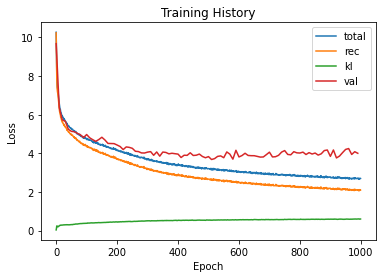

In [12]:
# Plot model loss/training progress
plt.plot(history.history['tot_loss'])
plt.plot(history.history['rec_loss'])
plt.plot(history.history['kl_loss'])
plt.plot(val_epochs, val_loss)
plt.title("Training History")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["total","rec","kl","val"], loc="upper right")
plt.show()

## Testing

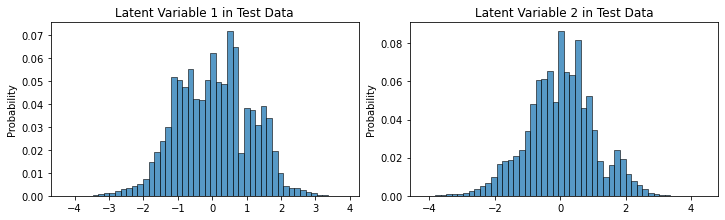

In [13]:
# Get latent vars from the encoder; feed to decoder and get sampled manifest variables
z_mean, z_logvar, z = vae.encoder.predict(test_data[:,:MANIFEST_DIM])

# Show distributions of the resulting variables
fig, axes = plt.subplots(nrows=1, ncols=LATENT_DIM, figsize=(10,3))
fig.tight_layout(w_pad=2, h_pad=10)

for i in range(LATENT_DIM):
    sns.histplot(z[:,i], ax=axes[i], bins=50, stat="probability")
    axes[i].set_title(f"Latent Variable {i+1} in Test Data")

In [14]:
# Draw predictions from test data
results = vae.predict(test_data)
loss_cat = VAE.get_reconstruction_loss(test_data, results, CAT_LENGTHS)
print(f"Categorical Variable Loss: {loss_cat}")

Categorical Variable Loss: 4.099630355834961


In [15]:
# Convert the testing data from ohe to values
test_data_df = pd.DataFrame()
for i, x in enumerate(results[0]):
    result = np.apply_along_axis(DataProcessor.logit_to_val, 1, x, pums_encodings_list[i])
    result_df = pd.DataFrame(result).add_prefix(f"{VAR_NAMES[i]}_")
    test_data_df = pd.concat([test_data_df, result_df], axis=1)
test_data_df.columns = VAR_NAMES

# Convert the test results from logits to values
test_results_df = pd.DataFrame()
for i, x in enumerate(results[0]):
    result = np.apply_along_axis(DataProcessor.logit_to_val, 1, x, pums_encodings_list[i])
    result_df = pd.DataFrame(result).add_prefix(f"{VAR_NAMES[i]}_")
    test_results_df = pd.concat([test_results_df, result_df], axis=1)
test_results_df.columns = VAR_NAMES

In [16]:
# # Show distributions of the resulting variables
# fig, axes = plt.subplots(nrows=len(VAR_NAMES), ncols=2, figsize=(10,10))
# fig.tight_layout(h_pad=4)

# for i, col in enumerate(VAR_NAMES):
#     sns.histplot(test_results_df[col], ax=axes[i,0], stat='probability', bins=100).set(xlim=(min(test_data_df[col]),max(test_data_df[col])))
#     axes[i,0].set_title(col)
#     axes[i,0].set_xlabel(None)
#     sns.histplot(test_data_df[col], ax=axes[i,1], stat='probability', bins=100).set(xlim=(min(test_data_df[col]),max(test_data_df[col])))
#     axes[i,1].set_title(col)
#     axes[i,1].set_xlabel(None)

## Generating Synthetic Population

In [17]:
# How many synthetic households to generate
POP_SIZE = 100000  # Number of hh in WA

# Generate random normal sample to represent each latent variable, for each row (different hh per row)
inputs = np.random.normal(loc=0, scale=1, size=(POP_SIZE, LATENT_DIM))

start_time = time.time()

# Generate households; each hh has unique latent input
results = vae.decoder.predict([inputs, inputs[:,LATENT_DIM:]])  # Nothing is actually in the second input

print(f"--- {time.time() - start_time} seconds ---")

--- 2.6284360885620117 seconds ---


In [18]:
# Save raw output values to be conditional inputs for the person CVAE
synth_hh_ohe_df = pd.DataFrame()
synth_hh_df = pd.DataFrame()
for i, x in enumerate(results[0]):
    result = np.apply_along_axis(DataProcessor.logit_to_ohe, 1, x)  # Most variables in PUMS are indexed from 1
    result_df = pd.DataFrame(result).add_prefix(f"{VAR_NAMES[i]}_")
    synth_hh_ohe_df = pd.concat([synth_hh_ohe_df, result_df], axis=1)
    
    result = np.apply_along_axis(DataProcessor.logit_to_val, 1, x, pums_encodings_list[i])
    result_df = pd.DataFrame(result).add_prefix(f"{VAR_NAMES[i]}_")
    synth_hh_df = pd.concat([synth_hh_df, result_df], axis=1)

synth_hh_df.columns = VAR_NAMES

synth_hh_df.to_csv('data/synthetic_populations/wa_households.csv', index=False)
synth_hh_ohe_df.to_csv('data/synthetic_populations/wa_households_raw.csv', index=False)

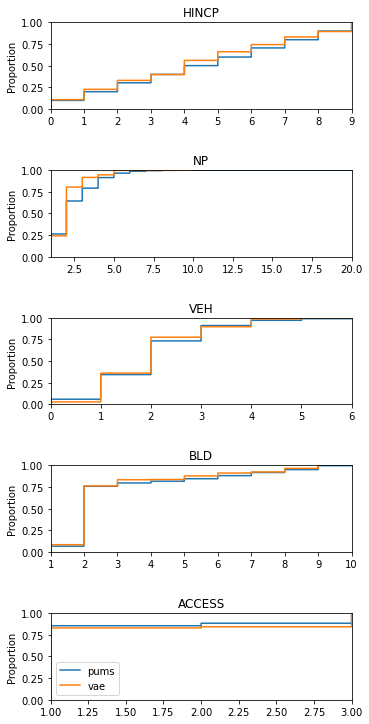

In [19]:
# Generate Distributions of All HH variables
fig, axes = plt.subplots(nrows=len(VAR_NAMES), ncols=1, figsize=(5,10))
fig.tight_layout(h_pad=4)

for i, var in enumerate(VAR_NAMES):
    sns.ecdfplot(data=pums_data, x=var, ax=axes[i]).set(xlim=(min(pums_data[var]),max(pums_data[var])))
    sns.ecdfplot(data=synth_hh_df, x=var, ax=axes[i]).set(xlim=(min(pums_data[var]),max(pums_data[var])))
    axes[i].set_title(var)
    axes[i].set_xlabel(None)
    plt.legend(labels=['pums','vae'])

In [20]:
# # Show distributions of the resulting variables
# fig, axes = plt.subplots(nrows=len(VAR_NAMES), ncols=2, figsize=(10,10))
# fig.tight_layout(h_pad=2, w_pad=2)

# for i, col in enumerate(VAR_NAMES):
#     sns.histplot(synth_hh_df[col], ax=axes[i,0], stat='probability', bins=100).set(xlim=(min(pums_data[col]),max(pums_data[col])))
#     axes[i,0].set_title(col)
#     axes[i,0].set_xlabel(None)
#     sns.histplot(pums_data[col], ax=axes[i,1], stat='probability', bins=100).set(xlim=(min(pums_data[col]),max(pums_data[col])))
#     axes[i,1].set_title(col)
#     axes[i,1].set_xlabel(None)

In [21]:
testModel(test_vae=vae, latent_dim=LATENT_DIM)
# gen_time, srmse_uni, srmse_bi

Univariate (marginal) SRMSE: 0.099185753870291
Bivariate (joint) SRMSE: 0.04226062091504851


(2.4765625, 0.099185753870291, 0.04226062091504851)